In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("tensorflow version :{}".format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tensorflow version :2.13.0
Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9669030001670532220
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14357954560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2611464694157410851
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#### physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

In [ ]:

from keras.layers import Conv1D, Dense, Dropout, GlobalMaxPool1D, MaxPool1D
from keras.layers import TimeDistributed, LSTM, Bidirectional, Input, concatenate,RepeatVector
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1,l2


In [ ]:
data_path = '/content/drive/MyDrive/CAV/data/Instant attack/25/'

In [ ]:
sensor1_data = pd.read_csv(data_path + "Sensor1_values_instant_25.csv", index_col= 'Unnamed: 0')
sensor1_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
len(sensor1_data)

29800

In [ ]:
sensor1_label = pd.read_csv(data_path+"Ground_truth_instant_25_sensor1.csv", names=['Class'])
sensor1_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
len(sensor1_label)

29800

In [ ]:
sensor2_data = pd.read_csv(data_path + "Sensor2_values_instant_25.csv", index_col = "Unnamed: 0")
sensor2_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor2_label = pd.read_csv(data_path + "Ground_truth_instant_25_sensor2.csv",names=['Class'])
sensor2_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor3_data = pd.read_csv(data_path + "Sensor3_values_instant_25.csv", index_col = "Unnamed: 0")
sensor3_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor3_label = pd.read_csv(data_path + "Ground_truth_instant_25_sensor3.csv", names=['Class'])
sensor3_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_data['std_speed_5'] = sensor1_data['InVehicle_Longitudinal_Speed'].rolling(5, min_periods= 1, center= True).std()
sensor1_data['std_acc_5'] = sensor1_data['InVehicle_Longitudinal_Accel'].rolling(5, min_periods= 1, center= True).std()
sensor1_data['std_GPS_5'] = sensor1_data['GPS_Speed'].rolling(5, min_periods= 1, center= True).std()

In [ ]:
sensor1_data.columns

Index(['InVehicle_Longitudinal_Speed', 'GPS_Speed',
       'InVehicle_Longitudinal_Accel', 'std_speed_5', 'std_acc_5',
       'std_GPS_5'],
      dtype='object')

<Axes: >

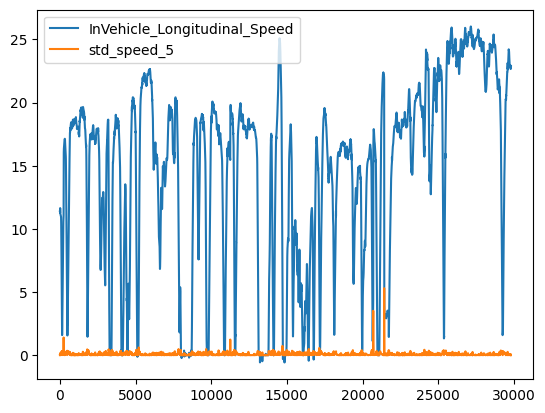

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Speed','std_speed_5']].plot()

<Axes: >

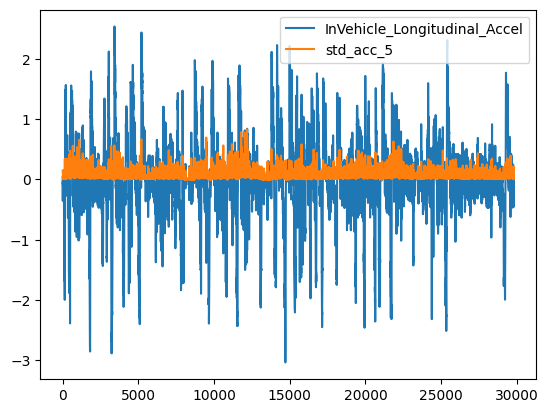

In [ ]:
sensor1_data[['InVehicle_Longitudinal_Accel','std_acc_5']].plot()

<Axes: >

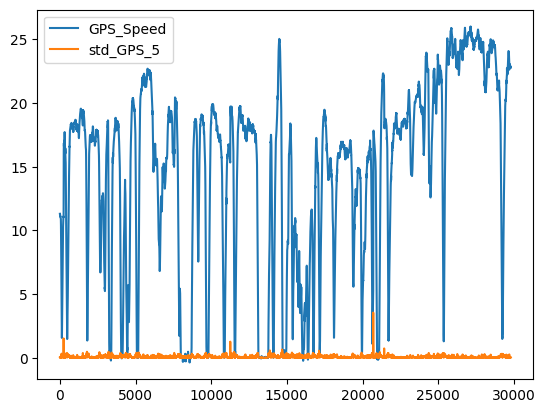

In [ ]:
sensor1_data[['GPS_Speed','std_GPS_5']].plot()

In [ ]:
sensor2_data['std_speed_5'] = sensor2_data['InVehicle_Longitudinal_Speed'].rolling(5, min_periods= 1, center= True).std()
sensor2_data['std_acc_5'] = sensor2_data['InVehicle_Longitudinal_Accel'].rolling(5, min_periods= 1, center= True).std()
sensor2_data['std_GPS_5'] = sensor2_data['GPS_Speed'].rolling(5, min_periods= 1, center= True).std()

In [ ]:
sensor2_data.columns

Index(['InVehicle_Longitudinal_Speed', 'GPS_Speed',
       'InVehicle_Longitudinal_Accel', 'std_speed_5', 'std_acc_5',
       'std_GPS_5'],
      dtype='object')

<Axes: >

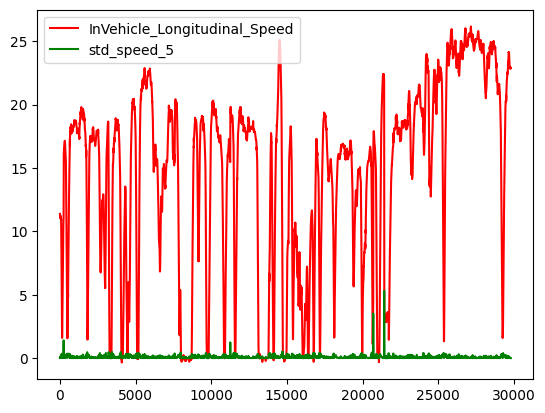

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Speed','std_speed_5']].plot(color=['red', 'green'] )

<Axes: >

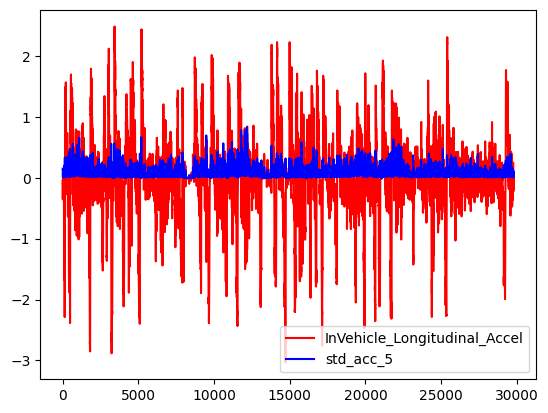

In [ ]:
sensor2_data[['InVehicle_Longitudinal_Accel','std_acc_5']].plot(color=['red', 'blue'] )

<Axes: >

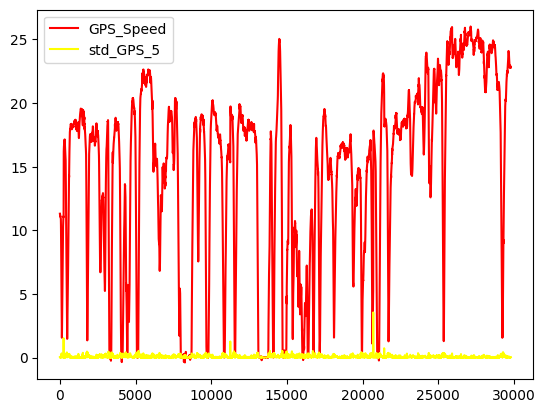

In [ ]:
sensor2_data[['GPS_Speed','std_GPS_5']].plot(color=['red', 'yellow'] )

In [ ]:
sensor3_data['std_speed_5'] = sensor3_data['InVehicle_Longitudinal_Speed'].rolling(5, min_periods= 1, center= True).std()
sensor3_data['std_acc_5'] = sensor3_data['InVehicle_Longitudinal_Accel'].rolling(5, min_periods= 1, center= True).std()
sensor3_data['std_GPS_5'] = sensor3_data['GPS_Speed'].rolling(5, min_periods= 1, center= True).std()

In [ ]:
sensor3_data.columns

Index(['InVehicle_Longitudinal_Speed', 'GPS_Speed',
       'InVehicle_Longitudinal_Accel', 'std_speed_5', 'std_acc_5',
       'std_GPS_5'],
      dtype='object')

<Axes: >

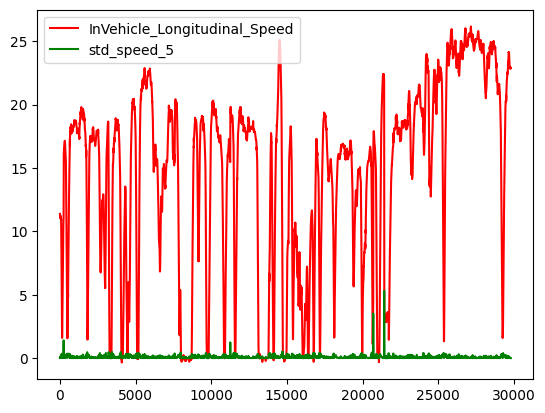

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Speed','std_speed_5']].plot(color=['red', 'green'] )

<Axes: >

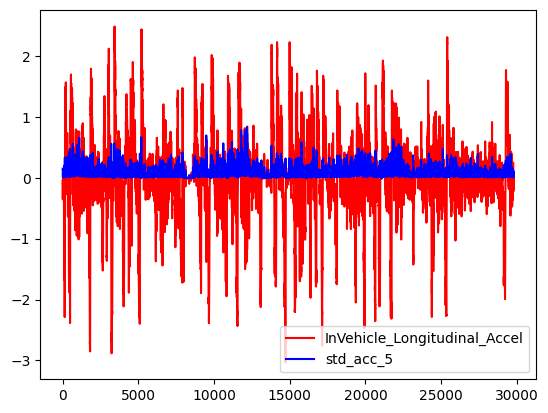

In [ ]:
sensor3_data[['InVehicle_Longitudinal_Accel','std_acc_5']].plot(color=['red', 'blue'] )

<Axes: >

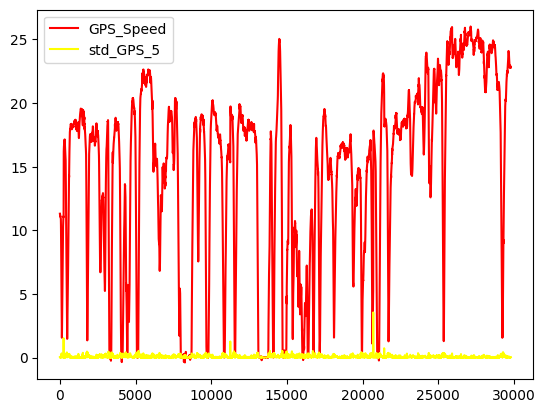

In [ ]:
sensor3_data[['GPS_Speed','std_GPS_5']].plot(color=['red', 'yellow'] )

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor1_data[['std_speed_5','std_GPS_5','std_acc_5']])
sensor1_data_normal = scaler.transform(sensor1_data[['std_speed_5','std_GPS_5','std_acc_5']])
sensor1_data_normal[:5]

array([[-0.57721209, -0.42674685,  0.77920953],
       [-0.57191965, -0.48390243,  0.66549642],
       [-0.56969861, -0.51987624,  0.54692016],
       [-0.59396927, -0.66913631,  0.6213872 ],
       [-0.60151216, -0.66509592, -0.84774735]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor2_data[['std_speed_5','std_GPS_5','std_acc_5']])
sensor2_data_normal = scaler.transform(sensor2_data[['std_speed_5','std_GPS_5','std_acc_5']])
sensor2_data_normal[:5]

array([[-0.57937438, -0.42353399,  0.78663982],
       [-0.57407373, -0.48062088,  0.6725265 ],
       [-0.57184924, -0.51655144,  0.5535329 ],
       [-0.59615755, -0.66563209,  0.62826203],
       [-0.60371215, -0.66159656, -0.84604324]])

In [ ]:
scaler  = StandardScaler()
scaler.fit(sensor3_data[['std_speed_5','std_GPS_5','std_acc_5']])
sensor3_data_normal = scaler.transform(sensor3_data[['std_speed_5','std_GPS_5','std_acc_5']])
sensor3_data_normal[:5]

array([[-0.57937438, -0.42353399,  0.78663982],
       [-0.57407373, -0.48062088,  0.6725265 ],
       [-0.57184924, -0.51655144,  0.5535329 ],
       [-0.59615755, -0.66563209,  0.62826203],
       [-0.60371215, -0.66159656, -0.84604324]])

In [ ]:
window_size = 10

# create windows with overlap
def convertToFrames(X_data,y_data, step):
    X, Y =[], []
    for i in range(len(X_data)-step):
        y_or = 0
        d=i+step
        X.append(X_data[i:d,])
        for y in y_data.iloc[i:d].values:
           y_or = y_or or y

        Y.append(y_or)
    return np.array(X), np.array(Y)

In [ ]:
X_sensor1, y_sensor1 = convertToFrames(sensor1_data_normal, sensor1_label, window_size)
X_sensor1.shape, y_sensor1.shape
# print(X_sensor1[0])
# print(X_sensor1[1])

((29790, 10, 3), (29790, 1))

In [ ]:
X_sensor2, y_sensor2 = convertToFrames(sensor2_data_normal, sensor2_label, window_size)
X_sensor2.shape, y_sensor2.shape

((29790, 10, 3), (29790, 1))

In [ ]:
X_sensor3, y_sensor3 = convertToFrames(sensor3_data_normal, sensor3_label, window_size)
X_sensor3.shape, y_sensor3.shape

((29790, 10, 3), (29790, 1))

In [ ]:
y_sensor1 = to_categorical(y_sensor1, num_classes= 2, dtype='float32')
y_sensor2 = to_categorical(y_sensor2, num_classes= 2, dtype='float32')
y_sensor3 = to_categorical(y_sensor3, num_classes= 2, dtype='float32')
y_sensor1.shape, y_sensor2.shape, y_sensor3.shape

((29790, 2), (29790, 2), (29790, 2))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(X_sensor1):
    # Split the data based on the indices
    X_train_sensor1, X_test_sensor1 = X_sensor1[train_index], X_sensor1[test_index]
    y_train_sensor1, y_test_sensor1 = y_sensor1[train_index], y_sensor1[test_index]

for train_index, test_index in tscv.split(X_sensor2):
    # Split the data based on the indices
    X_train_sensor2, X_test_sensor2 = X_sensor2[train_index], X_sensor2[test_index]
    y_train_sensor2, y_test_sensor2 = y_sensor2[train_index], y_sensor2[test_index]

for train_index, test_index in tscv.split(X_sensor3):
    # Split the data based on the indices
    X_train_sensor3, X_test_sensor3 = X_sensor3[train_index], X_sensor3[test_index]
    y_train_sensor3, y_test_sensor3 = y_sensor3[train_index], y_sensor3[test_index]

In [ ]:
X_train_sensor1.shape, X_test_sensor1.shape,y_train_sensor1.shape, y_test_sensor1.shape

((27082, 10, 3), (2708, 10, 3), (27082, 2), (2708, 2))

In [ ]:
X_train_sensor2.shape, X_test_sensor2.shape,y_train_sensor2.shape, y_test_sensor2.shape

((27082, 10, 3), (2708, 10, 3), (27082, 2), (2708, 2))

In [ ]:
X_train_sensor3.shape, X_test_sensor3.shape,y_train_sensor3.shape, y_test_sensor3.shape

((27082, 10, 3), (2708, 10, 3), (27082, 2), (2708, 2))

In [ ]:

def creatModel():

    model = Sequential()
    model.add(Conv1D(kernel_size=3, filters= 40, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    model.add( Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    model.add(Dropout(0.1))
    #model.add(Conv1D(kernel_size=3, filters= 60, activation= 'relu', padding='same'))
    #model.add(Dropout(0.1))
    model.add(GlobalMaxPool1D())
    model.add(RepeatVector(X_train_sensor1.shape[1]))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(rate=0.2))
    #model.add(LSTM(128, return_sequences=True))
    #model.add(Dropout(rate=0.2))
    #model.add(LSTM(64, return_sequences=False))
    #model.add(Dropout(rate=0.2))
    model.add((Dense(32)))
    model.add((Dense(16)))
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2()))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

    return model


In [ ]:
import time

class TimeHistory(Callback):

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        logs['epoch_time'] = epoch_time


In [ ]:
model_path = '/content/drive/MyDrive/CAV/data/Instant attack/25/Models/'

class Model_save(Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save(model_path + "CNN-LSTM-autoEncoder-Instant-25-CAV-perEpoch_{}.h5".format(sensor))


In [ ]:
def setCallbacks(sensor):

  best_model_path = model_path + 'Best_CNN-LSTM-autoEncoder-Instant-25-CAV_{}.h5'.format(sensor)
  checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

  history_cb = tf.keras.callbacks.CSVLogger(model_path + 'historyLOG_Instant-25_{}.csv'.format(sensor), separator=",", append=True)

  model_save = Model_save()

  Estop = EarlyStopping(monitor='val_accuracy', patience= 100)

  return model_save, checkpoint, history_cb, Estop

In [ ]:
sensor = "sensor1"
time_callback = TimeHistory()
model_sensor1 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor1")
history_sensor1 = model_sensor1.fit(X_train_sensor1, y_train_sensor1,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#


Epoch 1/500
191/191 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8557

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 25s 22ms/step - loss: 0.3964 - accuracy: 0.8557 - val_loss: 0.2996 - val_accuracy: 0.8977 - epoch_time: 24.7685
Epoch 2/500
191/191 [==============================] - 3s 15ms/step - loss: 0.2793 - accuracy: 0.9093 - val_loss: 0.2043 - val_accuracy: 0.9313 - epoch_time: 2.4566
Epoch 3/500
191/191 [==============================] - 3s 16ms/step - loss: 0.2281 - accuracy: 0.9271 - val_loss: 0.1648 - val_accuracy: 0.9487 - epoch_time: 3.0170
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1916 - accuracy: 0.9401 - val_loss: 0.1431 - val_accuracy: 0.9528 - epoch_time: 1.2770
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1805 - accuracy: 0.9433 - val_loss: 0.1464 - val_accuracy: 0.9550 - epoch_time: 1.2632
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1656 - accuracy: 0.9483 - val_loss: 0.1365 - val_accuracy: 0.9605 - epoch_time: 1.2712
Epoch 7/500
191/191 [==

In [ ]:
print(model_sensor1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 40)            400       
                                                                 
 dropout (Dropout)           (None, 10, 40)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 60)            7260      
                                                                 
 dropout_1 (Dropout)         (None, 10, 60)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 60)                0         
 alMaxPooling1D)                                                 
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 60)            0         
 r)                                                     

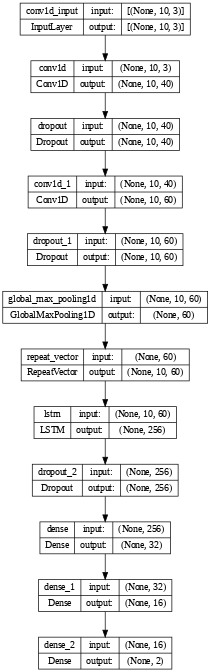

In [ ]:
plot_model(model= model_sensor1, show_shapes= True, dpi=50)

In [ ]:
sensor = "sensor2"
time_callback = TimeHistory()
model_sensor2 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor2")
history_sensor2 = model_sensor2.fit(X_train_sensor2, y_train_sensor2,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#

Epoch 1/500
191/191 [==============================] - 6s 10ms/step - loss: 0.3819 - accuracy: 0.8607 - val_loss: 0.2732 - val_accuracy: 0.9228 - epoch_time: 5.3902
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 0.2780 - accuracy: 0.9070 - val_loss: 0.2088 - val_accuracy: 0.9406 - epoch_time: 1.2921
Epoch 3/500
191/191 [==============================] - 2s 10ms/step - loss: 0.2272 - accuracy: 0.9272 - val_loss: 0.1883 - val_accuracy: 0.9480 - epoch_time: 1.7098
Epoch 4/500
191/191 [==============================] - 2s 10ms/step - loss: 0.2112 - accuracy: 0.9333 - val_loss: 0.1760 - val_accuracy: 0.9505 - epoch_time: 1.8115
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1987 - accuracy: 0.9363 - val_loss: 0.1716 - val_accuracy: 0.9498 - epoch_time: 1.2979
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1890 - accuracy: 0.9393 - val_loss: 0.1610 - val_accuracy: 0.9520 - epoch_time: 1.2625
Epoch 7/500
1

In [ ]:
sensor = "sensor3"
time_callback = TimeHistory()
model_sensor3 = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensor3")
history_sensor3 = model_sensor3.fit(X_train_sensor3, y_train_sensor3,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#

Epoch 1/500
191/191 [==============================] - 6s 11ms/step - loss: 0.4474 - accuracy: 0.8503 - val_loss: 0.5058 - val_accuracy: 0.7999 - epoch_time: 5.6087
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 0.4138 - accuracy: 0.8555 - val_loss: 0.4859 - val_accuracy: 0.8055 - epoch_time: 1.2688
Epoch 3/500
191/191 [==============================] - 1s 8ms/step - loss: 0.3952 - accuracy: 0.8608 - val_loss: 0.4883 - val_accuracy: 0.8117 - epoch_time: 1.3594
Epoch 4/500
191/191 [==============================] - 2s 10ms/step - loss: 0.3762 - accuracy: 0.8671 - val_loss: 0.4554 - val_accuracy: 0.8188 - epoch_time: 1.7868
Epoch 5/500
191/191 [==============================] - 2s 9ms/step - loss: 0.3666 - accuracy: 0.8703 - val_loss: 0.4401 - val_accuracy: 0.8250 - epoch_time: 1.6869
Epoch 6/500
191/191 [==============================] - 1s 7ms/step - loss: 0.3627 - accuracy: 0.8710 - val_loss: 0.4317 - val_accuracy: 0.8254 - epoch_time: 1.2931
Epoch 7/500
19

In [ ]:
#plot history of model_sensor1
history_sensor1 = pd.read_csv(model_path +"historyLOG_Instant-25_sensor1.csv", index_col='epoch')
history_sensor1.reset_index(drop= True, inplace= True)
history_sensor1.head()
print('Average Exe_time for sensor1: {} sec.'.format(round(np.mean(history_sensor1['epoch_time'].values),3)))


Average Exe_time for sensor1: 1.57 sec.


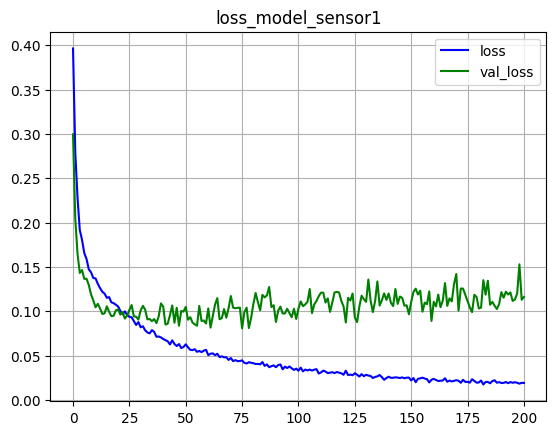

In [ ]:
plt.plot( history_sensor1['loss'], 'b',label = 'loss')
plt.plot( history_sensor1['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor1')
plt.show()

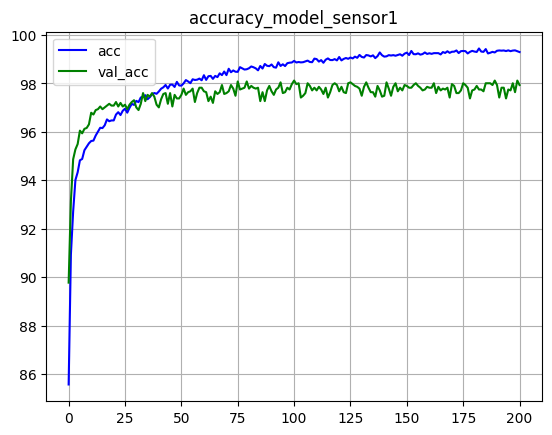

In [ ]:
plt.plot(history_sensor1['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor1['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor1')
plt.show()

In [ ]:
history_sensor2 = pd.read_csv(model_path +"historyLOG_Instant-25_sensor2.csv", index_col='epoch')
history_sensor2.reset_index(drop= True, inplace= True)
history_sensor2.head()
print('Average Exe_time for sensor2: {} sec.'.format(round(np.mean(history_sensor2['epoch_time'].values),3)))


Average Exe_time for sensor2: 1.449 sec.


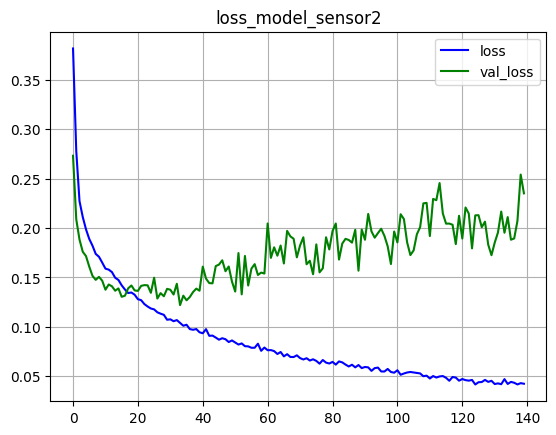

In [ ]:
plt.plot( history_sensor2['loss'], 'b',label = 'loss')
plt.plot( history_sensor2['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor2')
plt.show()

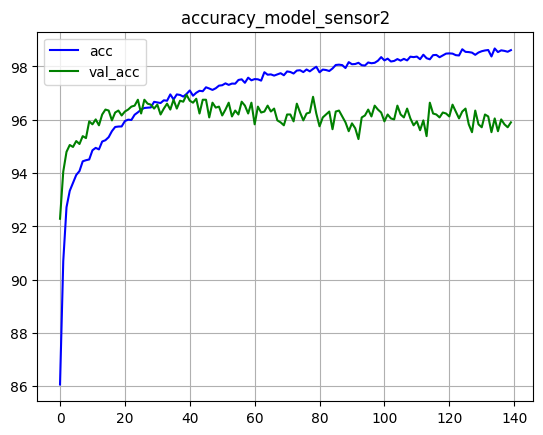

In [ ]:
plt.plot(history_sensor2['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor2['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor2')
plt.show()

In [ ]:
history_sensor3 = pd.read_csv(model_path +"historyLOG_Instant-25_sensor3.csv", index_col='epoch')
history_sensor3.reset_index(drop= True, inplace= True)
history_sensor3.head()
print('Average Exe_time for sensor3: {} sec.'.format(round(np.mean(history_sensor3['epoch_time'].values),3)))


Average Exe_time for sensor3: 1.458 sec.


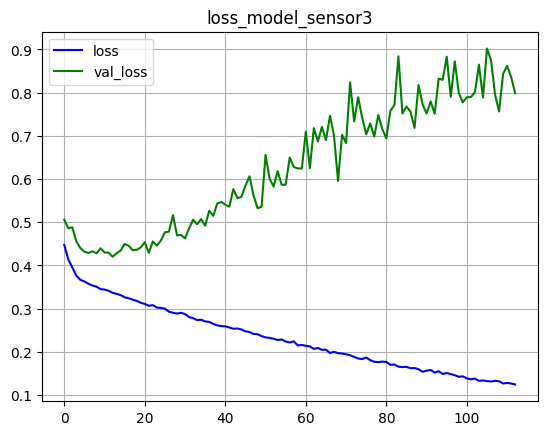

In [ ]:
plt.plot( history_sensor3['loss'], 'b',label = 'loss')
plt.plot( history_sensor3['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensor3')
plt.show()

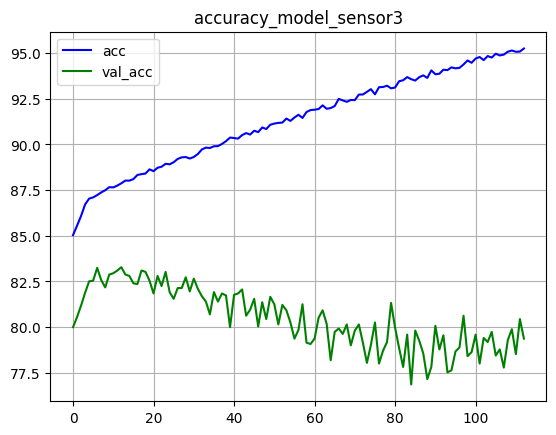

In [ ]:
plt.plot(history_sensor3['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensor3['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensor3')
plt.show()

In [ ]:
#last model_sensor1 evaluation
test_loss, test_acc = model_sensor1.evaluate( X_test_sensor1, y_test_sensor1, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9823
test accuracy :98.2% 
 test loss :0.0787


In [ ]:
#last model_sensor2 evaluation
test_loss, test_acc = model_sensor2.evaluate( X_test_sensor2, y_test_sensor2, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 3ms/step - loss: 0.2575 - accuracy: 0.9546
test accuracy :95.5% 
 test loss :0.257


In [ ]:
#last model_sensor3 evaluation
test_loss, test_acc = model_sensor3.evaluate( X_test_sensor3, y_test_sensor3, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.8113
test accuracy :81.1% 
 test loss :0.713


In [ ]:
y_pred_sensor1 = model_sensor1.predict( X_test_sensor1, verbose= 1)
y_pred_sensor2 = model_sensor2.predict( X_test_sensor2, verbose= 1)
y_pred_sensor3 = model_sensor3.predict( X_test_sensor3, verbose= 1)

85/85 [==============================] - 1s 2ms/step


In [ ]:
y_pred_sensor1 = [np.argmax(i) for i in y_pred_sensor1]
y_pred_sensor2 = [np.argmax(i) for i in y_pred_sensor2]
y_pred_sensor3 = [np.argmax(i) for i in y_pred_sensor3]

In [ ]:
y_pred_total = []
for i in range(len(y_pred_sensor1)):
  y_pred_total.append( y_pred_sensor1[i] or y_pred_sensor2[i] or y_pred_sensor3[i])

In [ ]:
assert(len(y_pred_total) == len(y_pred_sensor1))

In [ ]:
y_test_sensor1 = [np.argmax(i) for i in y_test_sensor1]
y_test_sensor2 = [np.argmax(i) for i in y_test_sensor2]
y_test_sensor3 = [np.argmax(i) for i in y_test_sensor3]

In [ ]:
y_test_total = []
for i in range(len(y_test_sensor1)):
  y_test_total.append(y_test_sensor1[i] or y_test_sensor2[i] or y_test_sensor3[i])

In [ ]:
print("Sensor 1 performanace:")
recall = recall_score(y_test_sensor1, y_pred_sensor1, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor1, y_pred_sensor1, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor1, y_pred_sensor1, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor1, y_pred_sensor1)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 1 performanace:
recall score : 98.23%

precision score: 98.23%

F1 score: 98.23%

accuracy score: 98.23%



In [ ]:
print("Sensor 2 performanace:")
recall = recall_score(y_test_sensor2, y_pred_sensor2, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor2, y_pred_sensor2, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor2, y_pred_sensor2, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor2, y_pred_sensor2)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 2 performanace:
recall score : 95.46%

precision score: 95.46%

F1 score: 95.46%

accuracy score: 95.46%



In [ ]:
print("Sensor 3 performanace:")
recall = recall_score(y_test_sensor3, y_pred_sensor3, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensor3, y_pred_sensor3, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensor3, y_pred_sensor3, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensor3, y_pred_sensor3)
print("accuracy score: {:.2%}\n".format(accuracy))

Sensor 3 performanace:
recall score : 81.13%

precision score: 81.13%

F1 score: 81.13%

accuracy score: 81.13%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_total, y_pred_total, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_total, y_pred_total, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_total, y_pred_total, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_total, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 81.79%

precision score: 81.79%

F1 score: 81.79%

accuracy score: 81.79%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_total, y_pred_total, average='macro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_total, y_pred_total, average='macro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_total, y_pred_total, average='macro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_total, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 79.22%

precision score: 81.28%

F1 score: 79.98%

accuracy score: 81.79%



In [ ]:
conf = confusion_matrix(y_test_total, y_pred_total, labels=[1,0])
conf_df = pd.DataFrame(conf, columns= [1,0], index= [1,0])
conf_df

,1,0
1,700,316
0,177,1515
